In [14]:
import pandas as pd
import numpy as np
import os
import re
import time
import datetime
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

import numba
import ast
import cv2
from glob import glob

from numba import jit
from typing import List, Union, Tuple
from math import sqrt

In [15]:
train_df = pd.read_csv("../Data_Set/Origin_Data/train.csv")
train_df

,class_id,xmin,ymin,xmax,ymax,label
0,00000.jpg,0.000000,41.558442,597.922078,571.428571,squid_peanut
1,00000.jpg,558.441558,137.142857,740.259740,344.935065,cidar
2,00000.jpg,715.324675,69.610390,906.493506,395.844156,diget_ori
3,00000.jpg,902.337662,21.818182,1082.077922,362.597403,welchs
4,00000.jpg,270.649351,431.168831,505.454545,646.233766,diget_choco
...,...,...,...,...,...,...
14174,02001.jpg,621.245136,241.991701,815.486381,570.622407,diget_ori
14175,02001.jpg,779.626459,239.004149,1066.505837,662.240664,jjolbyung_noodle
14176,02001.jpg,1042.599222,252.946058,1238.832685,593.526971,welchs
14177,02001.jpg,563.470817,607.468880,1232.856031,835.518672,zec


In [16]:
image_ids = train_df['class_id'].unique()
valid_ids = image_ids[-655:]
train_ids = image_ids[:-655]

In [17]:
valid_df = train_df[train_df['class_id'].isin(valid_ids)]
train_df = train_df[train_df['class_id'].isin(train_ids)]

In [18]:
class customDataSet(object):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['class_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.df[self.df['class_id'] == image_id]
        image_name = image_id.split(".")[0]

        image = cv2.imread(f'{self.image_dir}/{image_name}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id

In [19]:
# Albumentations
def get_train_transform():
    return A.Compose([
        ToTensor(),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor(),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [20]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

DIR_DATA = "../Data_Set/Origin_Data/image_split/train"
train_dataset = customDataSet(train_df, DIR_DATA, get_train_transform())
valid_dataset = customDataSet(valid_df, DIR_DATA, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [21]:
train_dataset[0]

(tensor([[[0.7098, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137],
          [0.7098, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137],
          [0.7098, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137],
          ...,
          [0.7725, 0.7725, 0.7725,  ..., 0.0078, 0.0078, 0.0078],
          [0.7725, 0.7725, 0.7725,  ..., 0.0078, 0.0078, 0.0078],
          [0.7725, 0.7725, 0.7725,  ..., 0.0078, 0.0078, 0.0078]],
 
         [[0.7569, 0.7529, 0.7529,  ..., 0.7843, 0.7843, 0.7843],
          [0.7569, 0.7529, 0.7529,  ..., 0.7843, 0.7843, 0.7843],
          [0.7569, 0.7529, 0.7529,  ..., 0.7843, 0.7843, 0.7843],
          ...,
          [0.8706, 0.8706, 0.8706,  ..., 0.0235, 0.0235, 0.0235],
          [0.8706, 0.8706, 0.8706,  ..., 0.0235, 0.0235, 0.0235],
          [0.8706, 0.8706, 0.8706,  ..., 0.0235, 0.0235, 0.0235]],
 
         [[0.8510, 0.8471, 0.8471,  ..., 0.8706, 0.8706, 0.8706],
          [0.8510, 0.8471, 0.8471,  ..., 0.8706, 0.8706, 0.8706],
          [0.8510, 0.8471, 0.8471,  ...,

In [22]:
valid_dataset[0]

(tensor([[[0.7333, 0.7294, 0.7255,  ..., 0.7255, 0.7255, 0.7255],
          [0.7333, 0.7294, 0.7255,  ..., 0.7255, 0.7255, 0.7255],
          [0.7333, 0.7294, 0.7255,  ..., 0.7255, 0.7255, 0.7255],
          ...,
          [0.6980, 0.6980, 0.6980,  ..., 0.1333, 0.1333, 0.1294],
          [0.6941, 0.6941, 0.6941,  ..., 0.1333, 0.1333, 0.1294],
          [0.6941, 0.6941, 0.6941,  ..., 0.1333, 0.1333, 0.1294]],
 
         [[0.7765, 0.7725, 0.7647,  ..., 0.7922, 0.7922, 0.7922],
          [0.7765, 0.7725, 0.7647,  ..., 0.7922, 0.7922, 0.7922],
          [0.7725, 0.7686, 0.7647,  ..., 0.7922, 0.7922, 0.7922],
          ...,
          [0.7176, 0.7176, 0.7176,  ..., 0.1529, 0.1529, 0.1490],
          [0.7137, 0.7137, 0.7137,  ..., 0.1529, 0.1529, 0.1490],
          [0.7137, 0.7137, 0.7137,  ..., 0.1529, 0.1529, 0.1490]],
 
         [[0.9020, 0.8980, 0.9020,  ..., 0.8941, 0.8941, 0.8941],
          [0.9020, 0.8980, 0.9020,  ..., 0.8941, 0.8941, 0.8941],
          [0.9098, 0.9059, 0.9020,  ...,

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


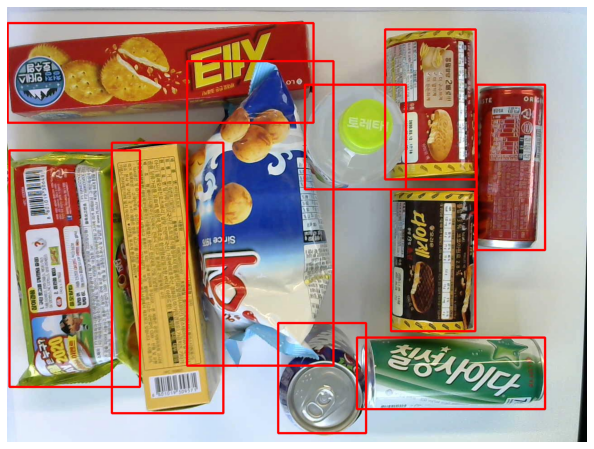

In [24]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Data

In [ ]:
import os

import torch
from torch.utils.data import DataLoader

from src.utils import dboxes300_coco, COCODetection
from src.utils import SSDTransformer
from src.coco import COCO
#DALI import
from src.coco_pipeline import COCOPipeline, DALICOCOIterator

def get_train_loader(args, local_seed):
    train_annotate = os.path.join(args.data, "annotations/instances_train2017.json")
    train_coco_root = os.path.join(args.data, "train2017")

    train_pipe = COCOPipeline(args.batch_size, args.local_rank, train_coco_root,
                    train_annotate, args.N_gpu, num_threads=args.num_workers,
                    output_fp16=args.amp, output_nhwc=False,
                    pad_output=False, seed=local_seed)
    train_pipe.build()
    test_run = train_pipe.schedule_run(), train_pipe.share_outputs(), train_pipe.release_outputs()
    train_loader = DALICOCOIterator(train_pipe, 118287 / args.N_gpu)
    return train_loader


def get_val_dataset(args):
    dboxes = dboxes300_coco()
    val_trans = SSDTransformer(dboxes, (300, 300), val=True)

    val_annotate = os.path.join(args.data, "annotations/instances_val2017.json")
    val_coco_root = os.path.join(args.data, "val2017")

    val_coco = COCODetection(val_coco_root, val_annotate, val_trans)
    return val_coco


def get_val_dataloader(dataset, args):
    if args.distributed:
        val_sampler = torch.utils.data.distributed.DistributedSampler(dataset)
    else:
        val_sampler = None

    val_dataloader = DataLoader(dataset,
                                batch_size=args.eval_batch_size,
                                shuffle=False,  # Note: distributed sampler is shuffled :(
                                sampler=val_sampler,
                                num_workers=args.num_workers)

    return val_dataloader

def get_coco_ground_truth(args):
    val_annotate = os.path.join(args.data, "annotations/instances_val2017.json")
    cocoGt = COCO(annotation_file=val_annotate)
    return cocoGt

# Utils

In [39]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import os
import numpy as np
import random
import itertools
import torch.nn.functional as F
import json
import time
import bz2
import pickle
from math import sqrt


# This function is from https://github.com/kuangliu/pytorch-ssd.
def calc_iou_tensor(box1, box2):
    """ Calculation of IoU based on two boxes tensor,
        Reference to https://github.com/kuangliu/pytorch-src
        input:
            box1 (N, 4)
            box2 (M, 4)
        output:
            IoU (N, M)
    """
    N = box1.size(0)
    M = box2.size(0)

    be1 = box1.unsqueeze(1).expand(-1, M, -1)
    be2 = box2.unsqueeze(0).expand(N, -1, -1)

    # Left Top & Right Bottom
    lt = torch.max(be1[:,:,:2], be2[:,:,:2])
    #mask1 = (be1[:,:, 0] < be2[:,:, 0]) ^ (be1[:,:, 1] < be2[:,:, 1])
    #mask1 = ~mask1
    rb = torch.min(be1[:,:,2:], be2[:,:,2:])
    #mask2 = (be1[:,:, 2] < be2[:,:, 2]) ^ (be1[:,:, 3] < be2[:,:, 3])
    #mask2 = ~mask2

    delta = rb - lt
    delta[delta < 0] = 0
    intersect = delta[:,:,0]*delta[:,:,1]
    #*mask1.float()*mask2.float()

    delta1 = be1[:,:,2:] - be1[:,:,:2]
    area1 = delta1[:,:,0]*delta1[:,:,1]
    delta2 = be2[:,:,2:] - be2[:,:,:2]
    area2 = delta2[:,:,0]*delta2[:,:,1]

    iou = intersect/(area1 + area2 - intersect)
    return iou


# This function is from https://github.com/kuangliu/pytorch-ssd.
class Encoder(object):
    """
        Inspired by https://github.com/kuangliu/pytorch-src
        Transform between (bboxes, lables) <-> SSD output
        dboxes: default boxes in size 8732 x 4,
            encoder: input ltrb format, output xywh format
            decoder: input xywh format, output ltrb format
        encode:
            input  : bboxes_in (Tensor nboxes x 4), labels_in (Tensor nboxes)
            output : bboxes_out (Tensor 8732 x 4), labels_out (Tensor 8732)
            criteria : IoU threshold of bboexes
        decode:
            input  : bboxes_in (Tensor 8732 x 4), scores_in (Tensor 8732 x nitems)
            output : bboxes_out (Tensor nboxes x 4), labels_out (Tensor nboxes)
            criteria : IoU threshold of bboexes
            max_output : maximum number of output bboxes
    """

    def __init__(self, dboxes):
        self.dboxes = dboxes(order="ltrb")
        self.dboxes_xywh = dboxes(order="xywh").unsqueeze(dim=0)
        self.nboxes = self.dboxes.size(0)
        self.scale_xy = dboxes.scale_xy
        self.scale_wh = dboxes.scale_wh

    def encode(self, bboxes_in, labels_in, criteria = 0.5):

        ious = calc_iou_tensor(bboxes_in, self.dboxes)
        best_dbox_ious, best_dbox_idx = ious.max(dim=0)
        best_bbox_ious, best_bbox_idx = ious.max(dim=1)

        # set best ious 2.0
        best_dbox_ious.index_fill_(0, best_bbox_idx, 2.0)

        idx = torch.arange(0, best_bbox_idx.size(0), dtype=torch.int64)
        best_dbox_idx[best_bbox_idx[idx]] = idx

        # filter IoU > 0.5
        masks = best_dbox_ious > criteria
        labels_out = torch.zeros(self.nboxes, dtype=torch.long)
        labels_out[masks] = labels_in[best_dbox_idx[masks]]
        bboxes_out = self.dboxes.clone()
        bboxes_out[masks, :] = bboxes_in[best_dbox_idx[masks], :]
        # Transform format to xywh format
        x, y, w, h = 0.5*(bboxes_out[:, 0] + bboxes_out[:, 2]), \
                     0.5*(bboxes_out[:, 1] + bboxes_out[:, 3]), \
                     -bboxes_out[:, 0] + bboxes_out[:, 2], \
                     -bboxes_out[:, 1] + bboxes_out[:, 3]
        bboxes_out[:, 0] = x
        bboxes_out[:, 1] = y
        bboxes_out[:, 2] = w
        bboxes_out[:, 3] = h
        return bboxes_out, labels_out

    def scale_back_batch(self, bboxes_in, scores_in):
        """
            Do scale and transform from xywh to ltrb
            suppose input Nx4xnum_bbox Nxlabel_numxnum_bbox
        """
        if bboxes_in.device == torch.device("cpu"):
            self.dboxes = self.dboxes.cpu()
            self.dboxes_xywh = self.dboxes_xywh.cpu()
        else:
            self.dboxes = self.dboxes.cuda()
            self.dboxes_xywh = self.dboxes_xywh.cuda()

        bboxes_in = bboxes_in.permute(0, 2, 1)
        scores_in = scores_in.permute(0, 2, 1)

        bboxes_in[:, :, :2] = self.scale_xy*bboxes_in[:, :, :2]
        bboxes_in[:, :, 2:] = self.scale_wh*bboxes_in[:, :, 2:]

        bboxes_in[:, :, :2] = bboxes_in[:, :, :2]*self.dboxes_xywh[:, :, 2:] + self.dboxes_xywh[:, :, :2]
        bboxes_in[:, :, 2:] = bboxes_in[:, :, 2:].exp()*self.dboxes_xywh[:, :, 2:]

        # Transform format to ltrb
        l, t, r, b = bboxes_in[:, :, 0] - 0.5*bboxes_in[:, :, 2],\
                     bboxes_in[:, :, 1] - 0.5*bboxes_in[:, :, 3],\
                     bboxes_in[:, :, 0] + 0.5*bboxes_in[:, :, 2],\
                     bboxes_in[:, :, 1] + 0.5*bboxes_in[:, :, 3]

        bboxes_in[:, :, 0] = l
        bboxes_in[:, :, 1] = t
        bboxes_in[:, :, 2] = r
        bboxes_in[:, :, 3] = b

        return bboxes_in, F.softmax(scores_in, dim=-1)

    def decode_batch(self, bboxes_in, scores_in,  criteria = 0.45, max_output=200):
        bboxes, probs = self.scale_back_batch(bboxes_in, scores_in)

        output = []
        for bbox, prob in zip(bboxes.split(1, 0), probs.split(1, 0)):
            bbox = bbox.squeeze(0)
            prob = prob.squeeze(0)
            output.append(self.decode_single(bbox, prob, criteria, max_output))
        return output

    # perform non-maximum suppression
    def decode_single(self, bboxes_in, scores_in, criteria, max_output, max_num=200):
        # Reference to https://github.com/amdegroot/ssd.pytorch

        bboxes_out = []
        scores_out = []
        labels_out = []

        for i, score in enumerate(scores_in.split(1, 1)):
            # skip background
            # print(score[score>0.90])
            if i == 0: continue
            # print(i)

            score = score.squeeze(1)
            mask = score > 0.05

            bboxes, score = bboxes_in[mask, :], score[mask]
            if score.size(0) == 0: continue

            score_sorted, score_idx_sorted = score.sort(dim=0)

            # select max_output indices
            score_idx_sorted = score_idx_sorted[-max_num:]
            candidates = []
            #maxdata, maxloc = scores_in.sort()

            while score_idx_sorted.numel() > 0:
                idx = score_idx_sorted[-1].item()
                bboxes_sorted = bboxes[score_idx_sorted, :]
                bboxes_idx = bboxes[idx, :].unsqueeze(dim=0)
                iou_sorted = calc_iou_tensor(bboxes_sorted, bboxes_idx).squeeze()
                # we only need iou < criteria
                score_idx_sorted = score_idx_sorted[iou_sorted < criteria]
                candidates.append(idx)

            bboxes_out.append(bboxes[candidates, :])
            scores_out.append(score[candidates])
            labels_out.extend([i]*len(candidates))

        if not bboxes_out:
            return [torch.tensor([]) for _ in range(3)]

        bboxes_out, labels_out, scores_out = torch.cat(bboxes_out, dim=0), \
               torch.tensor(labels_out, dtype=torch.long), \
               torch.cat(scores_out, dim=0)


        _, max_ids = scores_out.sort(dim=0)
        max_ids = max_ids[-max_output:]
        return bboxes_out[max_ids, :], labels_out[max_ids], scores_out[max_ids]


class DefaultBoxes(object):
    def __init__(self, fig_size, feat_size, steps, scales, aspect_ratios, \
                       scale_xy=0.1, scale_wh=0.2):

        self.feat_size = feat_size
        self.fig_size = fig_size

        self.scale_xy_ = scale_xy
        self.scale_wh_ = scale_wh

        # According to https://github.com/weiliu89/caffe
        # Calculation method slightly different from paper
        self.steps = steps
        self.scales = scales

        fk = fig_size/np.array(steps)
        self.aspect_ratios = aspect_ratios

        self.default_boxes = []
        # size of feature and number of feature
        for idx, sfeat in enumerate(self.feat_size):

            sk1 = scales[idx]/fig_size
            sk2 = scales[idx+1]/fig_size
            sk3 = sqrt(sk1*sk2)
            all_sizes = [(sk1, sk1), (sk3, sk3)]

            for alpha in aspect_ratios[idx]:
                w, h = sk1*sqrt(alpha), sk1/sqrt(alpha)
                all_sizes.append((w, h))
                all_sizes.append((h, w))
            for w, h in all_sizes:
                for i, j in itertools.product(range(sfeat), repeat=2):
                    cx, cy = (j+0.5)/fk[idx], (i+0.5)/fk[idx]
                    self.default_boxes.append((cx, cy, w, h))

        self.dboxes = torch.tensor(self.default_boxes, dtype=torch.float)
        self.dboxes.clamp_(min=0, max=1)
        # For IoU calculation
        self.dboxes_ltrb = self.dboxes.clone()
        self.dboxes_ltrb[:, 0] = self.dboxes[:, 0] - 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 1] = self.dboxes[:, 1] - 0.5 * self.dboxes[:, 3]
        self.dboxes_ltrb[:, 2] = self.dboxes[:, 0] + 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 3] = self.dboxes[:, 1] + 0.5 * self.dboxes[:, 3]

    @property
    def scale_xy(self):
        return self.scale_xy_

    @property
    def scale_wh(self):
        return self.scale_wh_

    def __call__(self, order="ltrb"):
        if order == "ltrb": return self.dboxes_ltrb
        if order == "xywh": return self.dboxes


def dboxes300_coco():
    figsize = 300
    feat_size = [38, 19, 10, 5, 3, 1]
    steps = [8, 16, 32, 64, 100, 300]
    # use the scales here: https://github.com/amdegroot/ssd.pytorch/blob/master/data/config.py
    scales = [21, 45, 99, 153, 207, 261, 315]
    aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
    dboxes = DefaultBoxes(figsize, feat_size, steps, scales, aspect_ratios)
    return dboxes


# This function is from https://github.com/chauhan-utk/ssd.DomainAdaptation.
class SSDCropping(object):
    """ Cropping for SSD, according to original paper
        Choose between following 3 conditions:
        1. Preserve the original image
        2. Random crop minimum IoU is among 0.1, 0.3, 0.5, 0.7, 0.9
        3. Random crop
        Reference to https://github.com/chauhan-utk/src.DomainAdaptation
    """
    def __init__(self):

        self.sample_options = (
            # Do nothing
            None,
            # min IoU, max IoU
            (0.1, None),
            (0.3, None),
            (0.5, None),
            (0.7, None),
            (0.9, None),
            # no IoU requirements
            (None, None),
        )

    def __call__(self, img, img_size, bboxes, labels):

        # Ensure always return cropped image
        while True:
            mode = random.choice(self.sample_options)

            if mode is None:
                return img, img_size, bboxes, labels

            htot, wtot = img_size

            min_iou, max_iou = mode
            min_iou = float("-inf") if min_iou is None else min_iou
            max_iou = float("+inf") if max_iou is None else max_iou

            # Implementation use 50 iteration to find possible candidate
            for _ in range(1):
                # suze of each sampled path in [0.1, 1] 0.3*0.3 approx. 0.1
                w = random.uniform(0.3 , 1.0)
                h = random.uniform(0.3 , 1.0)

                if w/h < 0.5 or w/h > 2:
                    continue

                # left 0 ~ wtot - w, top 0 ~ htot - h
                left = random.uniform(0, 1.0 - w)
                top = random.uniform(0, 1.0 - h)

                right = left + w
                bottom = top + h

                ious = calc_iou_tensor(bboxes, torch.tensor([[left, top, right, bottom]]))

                # tailor all the bboxes and return
                if not ((ious > min_iou) & (ious < max_iou)).all():
                    continue

                # discard any bboxes whose center not in the cropped image
                xc = 0.5*(bboxes[:, 0] + bboxes[:, 2])
                yc = 0.5*(bboxes[:, 1] + bboxes[:, 3])

                masks = (xc > left) & (xc < right) & (yc > top) & (yc < bottom)

                # if no such boxes, continue searching again
                if not masks.any():
                    continue

                bboxes[bboxes[:, 0] < left, 0] = left
                bboxes[bboxes[:, 1] < top, 1] = top
                bboxes[bboxes[:, 2] > right, 2] = right
                bboxes[bboxes[:, 3] > bottom, 3] = bottom

                bboxes = bboxes[masks, :]
                labels = labels[masks]

                left_idx = int(left*wtot)
                top_idx =  int(top*htot)
                right_idx = int(right*wtot)
                bottom_idx = int(bottom*htot)
                img = img.crop((left_idx, top_idx, right_idx, bottom_idx))

                bboxes[:, 0] = (bboxes[:, 0] - left)/w
                bboxes[:, 1] = (bboxes[:, 1] - top)/h
                bboxes[:, 2] = (bboxes[:, 2] - left)/w
                bboxes[:, 3] = (bboxes[:, 3] - top)/h

                htot = bottom_idx - top_idx
                wtot = right_idx - left_idx
                return img, (htot, wtot), bboxes, labels


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, bboxes):
        if random.random() < self.p:
            bboxes[:, 0], bboxes[:, 2] = 1.0 - bboxes[:, 2], 1.0 - bboxes[:, 0]
            return image.transpose(Image.FLIP_LEFT_RIGHT), bboxes
        return image, bboxes


# Do data augumentation
class SSDTransformer(object):
    """ SSD Data Augumentation, according to original paper
        Composed by several steps:
        Cropping
        Resize
        Flipping
        Jittering
    """
    def __init__(self, dboxes, size = (300, 300), val=False):

        # define vgg16 mean
        self.size = size
        self.val = val

        self.dboxes_ = dboxes #DefaultBoxes300()
        self.encoder = Encoder(self.dboxes_)

        self.crop = SSDCropping()
        self.img_trans = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ColorJitter(brightness=0.125, contrast=0.5,
                saturation=0.5, hue=0.05
            ),
            transforms.ToTensor()
        ])
        self.hflip = RandomHorizontalFlip()

        # All Pytorch Tensor will be normalized
        # https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])
        self.trans_val = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            #ToTensor(),
            self.normalize,])

    @property
    def dboxes(self):
        return self.dboxes_

    def __call__(self, img, img_size, bbox=None, label=None, max_num=200):
        #img = torch.tensor(img)
        if self.val:
            bbox_out = torch.zeros(max_num, 4)
            label_out =  torch.zeros(max_num, dtype=torch.long)
            bbox_out[:bbox.size(0), :] = bbox
            label_out[:label.size(0)] = label
            return self.trans_val(img), img_size, bbox_out, label_out

        img, img_size, bbox, label = self.crop(img, img_size, bbox, label)
        img, bbox = self.hflip(img, bbox)

        img = self.img_trans(img).contiguous()
        img = self.normalize(img)

        bbox, label = self.encoder.encode(bbox, label)

        return img, img_size, bbox, label


# Implement a datareader for COCO dataset
class COCODetection(data.Dataset):
    def __init__(self, img_folder, annotate_file, transform=None):
        self.img_folder = img_folder
        self.annotate_file = annotate_file

        # Start processing annotation
        with open(annotate_file) as fin:
            self.data = json.load(fin)

        self.images = {}

        self.label_map = {}
        self.label_info = {}
        start_time = time.time()
        # 0 stand for the background
        cnt = 0
        self.label_info[cnt] = "background"
        for cat in self.data["categories"]:
            cnt += 1
            self.label_map[cat["id"]] = cnt
            self.label_info[cnt] = cat["name"]

        # build inference for images
        for img in self.data["images"]:
            img_id = img["id"]
            img_name = img["file_name"]
            img_size = (img["height"],img["width"])
            if img_id in self.images: raise Exception("dulpicated image record")
            self.images[img_id] = (img_name, img_size, [])

        # read bboxes
        for bboxes in self.data["annotations"]:
            img_id = bboxes["image_id"]
            category_id = bboxes["category_id"]
            bbox = bboxes["bbox"]
            bbox_label = self.label_map[bboxes["category_id"]]
            self.images[img_id][2].append((bbox, bbox_label))

        for k, v in list(self.images.items()):
            if len(v[2]) == 0:
                self.images.pop(k)

        self.img_keys = list(self.images.keys())
        self.transform = transform

    @property
    def labelnum(self):
        return len(self.label_info)

    @staticmethod
    def load(pklfile):
        with bz2.open(pklfile, "rb") as fin:
            ret = pickle.load(fin)
        return ret

    def save(self, pklfile):
        with bz2.open(pklfile, "wb") as fout:
            pickle.dump(self, fout)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = self.img_keys[idx]
        img_data = self.images[img_id]
        fn = img_data[0]
        img_path = os.path.join(self.img_folder, fn)
        img = Image.open(img_path).convert("RGB")

        htot, wtot = img_data[1]
        bbox_sizes = []
        bbox_labels = []

        #for (xc, yc, w, h), bbox_label in img_data[2]:
        for (l,t,w,h), bbox_label in img_data[2]:
            r = l + w
            b = t + h
            #l, t, r, b = xc - 0.5*w, yc - 0.5*h, xc + 0.5*w, yc + 0.5*h
            bbox_size = (l/wtot, t/htot, r/wtot, b/htot)
            bbox_sizes.append(bbox_size)
            bbox_labels.append(bbox_label)

        bbox_sizes = torch.tensor(bbox_sizes)
        bbox_labels =  torch.tensor(bbox_labels)


        if self.transform != None:
            img, (htot, wtot), bbox_sizes, bbox_labels = \
                self.transform(img, (htot, wtot), bbox_sizes, bbox_labels)
        else:
            pass

        return img, img_id, (htot, wtot), bbox_sizes, bbox_labels


def draw_patches(img, bboxes, labels, order="xywh", label_map={}):

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    # Suppose bboxes in fractional coordinate:
    # cx, cy, w, h
    # img = img.numpy()
    img = np.array(img)
    labels = np.array(labels)
    bboxes = bboxes.numpy()

    if label_map:
        labels = [label_map.get(l) for l in labels]

    if order == "ltrb":
        xmin, ymin, xmax, ymax = bboxes[:, 0],  bboxes[:, 1],  bboxes[:, 2],  bboxes[:, 3]
        cx, cy, w, h = (xmin + xmax)/2, (ymin + ymax)/2, xmax - xmin, ymax - ymin
    else:
        cx, cy, w, h = bboxes[:, 0],  bboxes[:, 1],  bboxes[:, 2],  bboxes[:, 3]

    htot, wtot,_ = img.shape
    cx *= wtot
    cy *= htot
    w *= wtot
    h *= htot

    bboxes = zip(cx, cy, w, h)

    plt.imshow(img)
    ax = plt.gca()
    for (cx, cy, w, h), label in zip(bboxes, labels):
        if label == "background": continue
        ax.add_patch(patches.Rectangle((cx-0.5*w, cy-0.5*h),
                                        w, h, fill=False, color="r"))
        bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=0.3)
        ax.text(cx-0.5*w, cy-0.5*h, label, ha="center", va="center", size=15, bbox=bbox_props)
    plt.show()

In [36]:
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152

class ResNet(nn.Module):
    def __init__(self, backbone='resnet18', backbone_path=None):
        super().__init__()
        
        if backbone == 'resnet18':
            backbone = torch.load('./save/lotte_model_resnet18_v6.pt')
            self.out_channels = [256, 512, 512, 256, 256, 128]
#         if backbone == 'resnet18':
#             backbone = resnet18(pretrained=not backbone_path)
#             self.out_channels = [256, 512, 512, 256, 256, 128]
#         elif backbone == 'resnet34':
#             backbone = resnet34(pretrained=not backbone_path)
#             self.out_channels = [256, 512, 512, 256, 256, 256]
#         elif backbone == 'resnet50':
#             backbone = resnet50(pretrained=not backbone_path)
#             self.out_channels = [1024, 512, 512, 256, 256, 256]
#         elif backbone == 'resnet101':
#             backbone = resnet101(pretrained=not backbone_path)
#             self.out_channels = [1024, 512, 512, 256, 256, 256]
#         else:  # backbone == 'resnet152':
#             backbone = resnet152(pretrained=not backbone_path)
#             self.out_channels = [1024, 512, 512, 256, 256, 256]
            
        if backbone_path:
            backbone.load_state_dict(torch.load(backbone_path))

        self.feature_extractor = nn.Sequential(*list(backbone.children())[:7])

        conv4_block1 = self.feature_extractor[-1][0]

        conv4_block1.conv1.stride = (1, 1)
        conv4_block1.conv2.stride = (1, 1)
        conv4_block1.downsample[0].stride = (1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    
class SSD300(nn.Module):
    def __init__(self, backbone=ResNet('resnet18')):
        super().__init__()

        self.feature_extractor = backbone

        self.label_num = 23  # number of COCO classes
        self._build_additional_features(self.feature_extractor.out_channels)
        self.num_defaults = [4, 6, 6, 6, 4, 4]
        self.loc = []
        self.conf = []

        for nd, oc in zip(self.num_defaults, self.feature_extractor.out_channels):
            self.loc.append(nn.Conv2d(oc, nd * 4, kernel_size=3, padding=1))
            self.conf.append(nn.Conv2d(oc, nd * self.label_num, kernel_size=3, padding=1))

        self.loc = nn.ModuleList(self.loc)
        self.conf = nn.ModuleList(self.conf)
        self._init_weights()

    def _build_additional_features(self, input_size):
        self.additional_blocks = []
        for i, (input_size, output_size, channels) in enumerate(zip(input_size[:-1], input_size[1:], [256, 256, 128, 128, 128])):
            if i < 3:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, padding=1, stride=2, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )
            else:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )

            self.additional_blocks.append(layer)

        self.additional_blocks = nn.ModuleList(self.additional_blocks)

    def _init_weights(self):
        layers = [*self.additional_blocks, *self.loc, *self.conf]
        for layer in layers:
            for param in layer.parameters():
                if param.dim() > 1: nn.init.xavier_uniform_(param)

    # Shape the classifier to the view of bboxes
    def bbox_view(self, src, loc, conf):
        ret = []
        for s, l, c in zip(src, loc, conf):
            ret.append((l(s).view(s.size(0), 4, -1), c(s).view(s.size(0), self.label_num, -1)))

        locs, confs = list(zip(*ret))
        locs, confs = torch.cat(locs, 2).contiguous(), torch.cat(confs, 2).contiguous()
        return locs, confs

    def forward(self, x):
        x = self.feature_extractor(x)

        detection_feed = [x]
        for l in self.additional_blocks:
            x = l(x)
            detection_feed.append(x)

        # Feature Map 38x38x4, 19x19x6, 10x10x6, 5x5x6, 3x3x4, 1x1x4
        locs, confs = self.bbox_view(detection_feed, self.loc, self.conf)

        # For SSD 300, shall return nbatch x 8732 x {nlabels, nlocs} results
        return locs, confs


class Loss(nn.Module):
    """
        Implements the loss as the sum of the followings:
        1. Confidence Loss: All labels, with hard negative mining
        2. Localization Loss: Only on positive labels
        Suppose input dboxes has the shape 8732x4
    """
    def __init__(self, dboxes):
        super(Loss, self).__init__()
        self.scale_xy = 1.0/dboxes.scale_xy
        self.scale_wh = 1.0/dboxes.scale_wh

        self.sl1_loss = nn.SmoothL1Loss(reduce=False)
        self.dboxes = nn.Parameter(dboxes(order="xywh").transpose(0, 1).unsqueeze(dim = 0),
            requires_grad=False)
        # Two factor are from following links
        # http://jany.st/post/2017-11-05-single-shot-detector-ssd-from-scratch-in-tensorflow.html
        self.con_loss = nn.CrossEntropyLoss(reduce=False)

    def _loc_vec(self, loc):
        """
            Generate Location Vectors
        """
        gxy = self.scale_xy*(loc[:, :2, :] - self.dboxes[:, :2, :])/self.dboxes[:, 2:, ]
        gwh = self.scale_wh*(loc[:, 2:, :]/self.dboxes[:, 2:, :]).log()
        return torch.cat((gxy, gwh), dim=1).contiguous()

    def forward(self, ploc, plabel, gloc, glabel):
        """
            ploc, plabel: Nx4x8732, Nxlabel_numx8732
                predicted location and labels
            gloc, glabel: Nx4x8732, Nx8732
                ground truth location and labels
        """
        mask = glabel > 0
        pos_num = mask.sum(dim=1)

        vec_gd = self._loc_vec(gloc)

        # sum on four coordinates, and mask
        sl1 = self.sl1_loss(ploc, vec_gd).sum(dim=1)
        sl1 = (mask.float()*sl1).sum(dim=1)

        # hard negative mining
        con = self.con_loss(plabel, glabel)

        # postive mask will never selected
        con_neg = con.clone()
        con_neg[mask] = 0
        _, con_idx = con_neg.sort(dim=1, descending=True)
        _, con_rank = con_idx.sort(dim=1)

        # number of negative three times positive
        neg_num = torch.clamp(3*pos_num, max=mask.size(1)).unsqueeze(-1)
        neg_mask = con_rank < neg_num

        #print(con.shape, mask.shape, neg_mask.shape)
        closs = (con*(mask.float() + neg_mask.float())).sum(dim=1)

        # avoid no object detected
        total_loss = sl1 + closs
        num_mask = (pos_num > 0).float()
        pos_num = pos_num.float().clamp(min=1e-6)
        ret = (total_loss*num_mask/pos_num).mean(dim=0)
        return ret

In [38]:
model = SSD300()
model

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo